<h1>Fitness Trackers Data Analysis in R</h2>

R for data analysis, and interfacing with IBM DB2 on Cloud and mongoDB.

<b>Challenge :</b> The challenge is that a retail company wants to include Fitness Trackers in its 
inventory, and needs to know more about at least 10 brands of the top Fitness Trackers to carry in 
terms of customer acceptance, which relates to sales, and subsequently minimize the risk for products 
that may not perform well in sales.

<h2>Data Analysis Goals</h2>

1. Determine correlation between customer ratings against other variables
2. Find Top Ten Brands Listed by Quantity
3. Find Top Ten Brands with Highest Customer Ratings
4. Find Top Ten Brands with Best Ratings Performance

This dataset contains 565 observations (samples) with 11 variables 
(column fields). There are some missing values in this dataset, notably the 
Reviews column, which we will not include in the analysis.

**Columns :**<br>
1. **Brand Name** : manufacturer of the product<br>
2. **Device Type**: two categories- FitnessBand and Smartwatch<br>
3. **Model Name** : Product model<br>
4. **Color** : color of the Strap or Body<br>
5. **Selling Price** : Selling Price or the Discounted Price<br>
6. **Original Price** : Manufacture Suggested Retail Price (MSRP)<br>
7. **Display** : type of display - eg: AMOLED, LCD,OLED, etc.<br>
8. **Rating** : Average customer ratings on a scale of 1 to 5<br>
9. **Strap Material** : material used for the strap of the fitness tracker<br>
10. **Average Battery Life (in days)** : Quoted average battery life from the<br>
    manufacturer based on the individual product pages. <br>
    (It is not the scraped data)<br>
11. **Reviews** : count of product reviews received<br>

<i>source : https://www.kaggle.com/devsubhash/fitness-trackers-products-ecommerce</i>

<h3>Section 1 : Install Needed Packages and load libraries</h3> 

In [20]:
# install needed packages

if("magrittr" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("magrittr")}
library(magrittr)

if("ggplot2" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("ggplot2")}
library(ggplot2)

if("ggthemes" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("ggthemes")}
library(ggthemes)

if("patchwork" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("patchwork")}
library(patchwork)

if("tidyverse" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("tidyverse")}
library(tidyverse)

if("mongolite" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("mongolite")}
library(mongolite)

if("RODBC" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("RODBC")}
library(RODBC)

if("corrplot" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("corrplot")}
library(corrplot)

<h3>Section 2A : IBM DB2 Connection</h3>

If no connection to IBM DB2, jump to Section 2B

<h3>Access data from IBM Db2 on Cloud database using RODBC</h3>

The csv dataset has been loaded in DB2 database through the DB2 Console.  By default, headers were 
changed to all caps, and dots in headers replaced with underscore. 

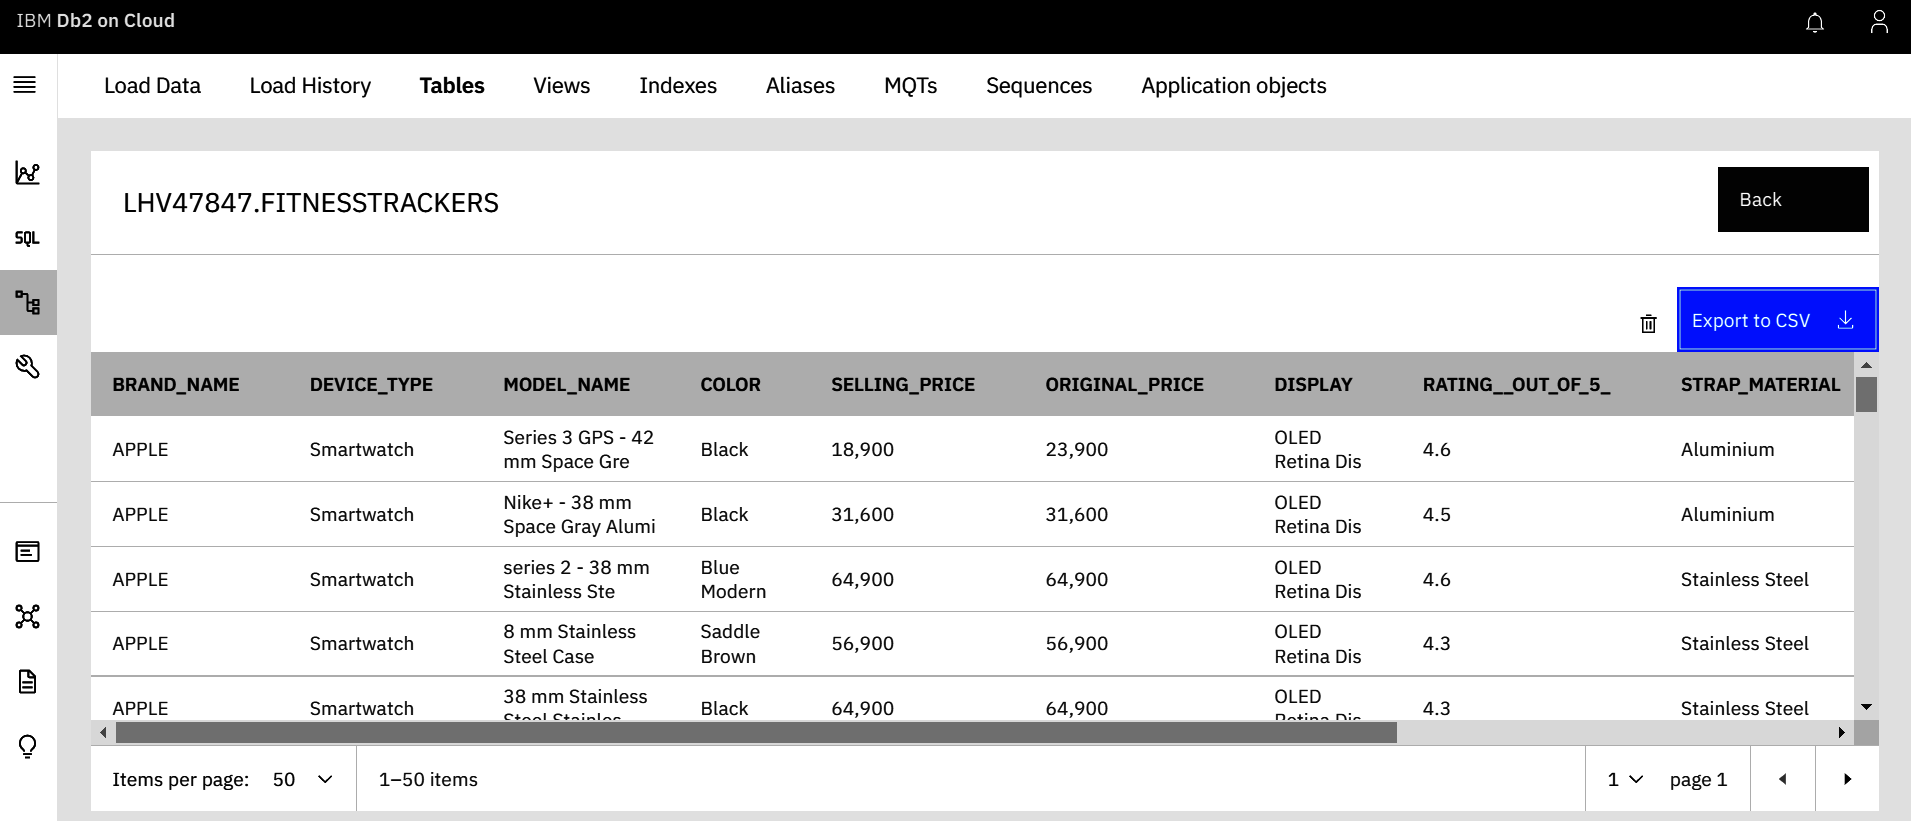

In [3]:
library(RODBC)     # we can also use RJDBC

In [4]:
#Enter the values for the database connection

dsn_driver = "{IBM DB2 ODBC Driver}"
dsn_database = "<your-database"   # e.g. "bludb"
dsn_hostname = "<your-hostname>"  # e.g. replace <yourhostname> with your hostname
dsn_port = "<your-dns-port>"      # e.g. "3273" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_uid = "your-db2-id"           # e.g. replace <username> with your userid
dsn_pwd = "your-password"         # e.g. replace <password> with your password
dsn_security <- "ssl"

In [5]:
# Create a connection string and connect to the database

conn_path <- paste("DRIVER=",dsn_driver,
                  ";DATABASE=",dsn_database,
                  ";HOSTNAME=",dsn_hostname,
                  ";PORT=",dsn_port,
                  ";PROTOCOL=",dsn_protocol,
                  ";UID=",dsn_uid,
                  ";PWD=",dsn_pwd,
                  ";SECURITY=",dsn_security,        
                    sep="")
conn <- odbcDriverConnect(conn_path)
conn

RODBC Connection 1
Details:
  case=nochange
  DRIVER={IBM DB2 ODBC DRIVER}
  UID=lhv47847
  PWD=******
  DATABASE=bludb
  HOSTNAME=ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud
  PORT=31321
  PROTOCOL=TCPIP
  SECURITY=SSL

In [6]:
# View database and driver information
sql.info <- sqlTypeInfo(conn)
conn.info <- odbcGetInfo(conn)
conn.info["DBMS_Name"]
conn.info["DBMS_Ver"]
conn.info["Driver_ODBC_Ver"]

DBMS_Name 
"DB2/LINUXX8664"

DBMS_Ver 
"11.05.0600"

Driver_ODBC_Ver 
        "03.51"

In [7]:
# fetch the database into a data frame
db2df <- sqlFetch(conn, "FITNESSTRACKERS")

In [8]:
# close db connection, a good practice
close(conn)

<h3>Section 2B : Run the code below if unable to run Section 2A</h3>
<br>
<b>*** No need to run if able to run Section 2A</b>

In [9]:
# Code to run if no IBM DB2 access.

db2df <- read.csv("C:/IBF-Learning/CDAS/Project/datasets/fitness_trackers.csv", 
                header = TRUE, 
                strip.white = TRUE,
                stringsAsFactors= FALSE)

# change headers to Uppercase
names(db2df) <- toupper(names(db2df))

# change "." to "_" in header nanmes
names(db2df) = gsub("\\.","_",names(db2df))

## View the results
names(db2df)

[1] "BRAND_NAME"                     "DEVICE_TYPE"                   
 [3] "MODEL_NAME"                     "COLOR"                         
 [5] "SELLING_PRICE"                  "ORIGINAL_PRICE"                
 [7] "DISPLAY"                        "RATING__OUT_OF_5_"             
 [9] "STRAP_MATERIAL"                 "AVERAGE_BATTERY_LIFE__IN_DAYS_"
[11] "REVIEWS"

<h3>Section 3 : View Data and Data Preeparation</h3>

In [9]:
head(db2df, 5)

,BRAND_NAME,DEVICE_TYPE,MODEL_NAME,COLOR,SELLING_PRICE,ORIGINAL_PRICE,DISPLAY,RATING__OUT_OF_5_,STRAP_MATERIAL,AVERAGE_BATTERY_LIFE__IN_DAYS_,REVIEWS
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>
1,Xiaomi,FitnessBand,Smart Band 5,Black,"2,499","2,999",AMOLED Display,4.1,Thermoplastic polyurethane,14,NA
2,Xiaomi,FitnessBand,Smart Band 4,Black,"2,099","2,499",AMOLED Display,4.2,Thermoplastic polyurethane,14,NA
3,Xiaomi,FitnessBand,HMSH01GE,Black,"1,722","2,099",LCD Display,3.5,Leather,14,NA
4,Xiaomi,FitnessBand,Smart Band 5,Black,"2,469","2,999",AMOLED Display,4.1,Thermoplastic polyurethane,14,NA
5,Xiaomi,FitnessBand,Band 3,Black,"1,799","2,199",OLED Display,4.3,Plastic,7,NA


<h2>Data Preparation</h2>

In [10]:
# Remove Reviews, most are NULL
df <- db2df %>% select(-REVIEWS)

# remove spaces in the column names to avoid any problems when we query it 
# from MongoDB.
names(df) = gsub(" ","",names(df))

# Rename names for easier usage
names(df)[names(df) == 'RATING__OUT_OF_5_'] <- "RATING"
names(df)[names(df) == 'AVERAGE_BATTERY_LIFE__IN_DAYS_'] <- 
    "AVG_BATTERY_LIFE"

# Convert some columns to numeric
df["SELLING_PRICE"] <- as.integer(gsub(",","",df$SELLING_PRICE))
df["ORIGINAL_PRICE"] <- as.integer(gsub(",","",df$ORIGINAL_PRICE))

# Remove rows where Rating is NA
df <- filter(df, RATING >= 1)

In [11]:
head(df, 3)

,BRAND_NAME,DEVICE_TYPE,MODEL_NAME,COLOR,SELLING_PRICE,ORIGINAL_PRICE,DISPLAY,RATING,STRAP_MATERIAL,AVG_BATTERY_LIFE
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<int>
1,Xiaomi,FitnessBand,Smart Band 5,Black,2499,2999,AMOLED Display,4.1,Thermoplastic polyurethane,14
2,Xiaomi,FitnessBand,Smart Band 4,Black,2099,2499,AMOLED Display,4.2,Thermoplastic polyurethane,14
3,Xiaomi,FitnessBand,HMSH01GE,Black,1722,2099,LCD Display,3.5,Leather,14


<h3>Section 4 : MongoDB Connection</h3>

<b>*** Skip to Section 5 if no MongoDB connection</b>

<h3>Load into MongoDB</h3>

In [38]:
library(datasets)

ft=mongo(collection="FitnessTrackers",db="FitnessTrackers")

In [353]:
ft$insert(df)   # inserts into MongoDB

List of 5
 $ nInserted  : num 514
 $ nMatched   : num 0
 $ nRemoved   : num 0
 $ nUpserted  : num 0
 $ writeErrors: list()

In [39]:
cat("Count : ", ft$count(),"\n\n")
cat("ft$info : ")
ft$info()

Count :  514 

ft$info : 

List of 4
 $ collection: chr "FitnessTrackers"
 $ db        : NULL
 $ stats     :List of 16
  ..$ ns             : chr "FitnessTrackers.FitnessTrackers"
  ..$ size           : int 135317
  ..$ count          : int 514
  ..$ avgObjSize     : int 263
  ..$ storageSize    : int 40960
  ..$ freeStorageSize: int 0
  ..$ capped         : logi FALSE
  ..$ wiredTiger     :List of 15
  ..$ nindexes       : int 1
  ..$ indexDetails   :List of 1
  ..$ indexBuilds    : list()
  ..$ totalIndexSize : int 20480
  ..$ totalSize      : int 61440
  ..$ indexSizes     :List of 1
  ..$ scaleFactor    : int 1
  ..$ ok             : num 1
 $ server    :List of 35
  ..$ host                     : chr "LAPTOP-R14UHMSB"
  ..$ version                  : chr "5.0.3"
  ..$ process                  : chr "C:\\Program Files\\MongoDB\\Server\\5.0\\bin\\mongod.exe"
  ..$ pid                      : num 4908
  ..$ uptime                   : num 334653
  ..$ uptimeMillis             : num 3.35e+08
  ..$ uptimeEstimate  

In [40]:
ft$iterate()$one()
class(ft)

$BRAND_NAME
[1] "Xiaomi"

$DEVICE_TYPE
[1] "FitnessBand"

$MODEL_NAME
[1] "Smart Band 5"

$COLOR
[1] "Black"

$SELLING_PRICE
[1] 2499

$ORIGINAL_PRICE
[1] 2999

$DISPLAY
[1] "AMOLED Display"

$RATING
[1] 4.1

$STRAP_MATERIAL
[1] "Thermoplastic polyurethane"

$AVG_BATTERY_LIFE
[1] 14

[1] "mongo"       "jeroen"      "environment"

In [16]:
# this command is used to convert a mongo object back to a dataframe

# df2 <- ft$find('{}')

<h2>Section 5 : Correlation</h2>

In [21]:
# customized corrplot

corrplot2 <- function(data,
                      method = "pearson",
                      sig.level = 0.05,
                      order = "original",
                      diag = FALSE,
                      type = "upper",
                      tl.srt = 90,
                      number.font = 1,
                      number.cex = 1,
                      mar = c(0, 0, 0, 0)) {
  library(corrplot)
  data_incomplete <- data
  data <- data[complete.cases(data), ]
  mat <- cor(data, method = method)
  cor.mtest <- function(mat, method) {
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- matrix(NA, n, n)
    diag(p.mat) <- 0
    for (i in 1:(n - 1)) {
      for (j in (i + 1):n) {
        tmp <- cor.test(mat[, i], mat[, j], method = method)
        p.mat[i, j] <- p.mat[j, i] <- tmp$p.value
      }
    }
    colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
    p.mat
  }
  p.mat <- cor.mtest(data, method = method)
  col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))
  corrplot(mat,
           method = "color", col = col(200), number.font = number.font,
           mar = mar, number.cex = number.cex,
           type = type, order = order,
           addCoef.col = "black", # add correlation coefficient
           tl.col = "black", tl.srt = tl.srt, # rotation of text labels
           # combine with significance level
           p.mat = p.mat, sig.level = sig.level, insig = "blank",
           # hide correlation coefficients on the diagonal
           diag = diag
  )
}

In [22]:
# correlate numeric variables

df1 <- select(df, RATING, AVG_BATTERY_LIFE, ORIGINAL_PRICE, SELLING_PRICE)

round(cor(df1), digits = 2)

,RATING,AVG_BATTERY_LIFE,ORIGINAL_PRICE,SELLING_PRICE
RATING,1.00,-0.16,0.30,0.30
AVG_BATTERY_LIFE,-0.16,1.00,-0.29,-0.30
ORIGINAL_PRICE,0.30,-0.29,1.00,0.98
SELLING_PRICE,0.30,-0.30,0.98,1.00


In [23]:
# customized corrplot

corrplot2 <- function(data,
                      method = "pearson",
                      sig.level = .05,
                      order = "original",
                      diag = FALSE,
                      type = "upper",
                      tl.srt = 90,
                      number.font = 1,
                      number.cex = 2,
                      mar = c(0, 5, 0, 0)) {
  library(corrplot)
  data_incomplete <- data
  data <- data[complete.cases(data), ]
  mat <- cor(data, method = method)
  cor.mtest <- function(mat, method) {
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- matrix(NA, n, n)
    diag(p.mat) <- 0
    for (i in 1:(n - 1)) {
      for (j in (i + 1):n) {
        tmp <- cor.test(mat[, i], mat[, j], method = method)
        p.mat[i, j] <- p.mat[j, i] <- tmp$p.value
      }
    }
    colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
    p.mat
  }
  p.mat <- cor.mtest(data, method = method)
  col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", 
                            "#4477AA"))
  corrplot(mat,
           method = "color", col = col(200), number.font = number.font,
           mar = mar, number.cex = number.cex,
           type = type, order = order,
           addCoef.col = "black", # add correlation coefficient
           tl.col = "black", tl.srt = tl.srt, # rotation of text labels
           # combine with significance level
           p.mat = p.mat, sig.level = sig.level, insig = "blank",
           # hide correlation coefficients on the diagonal
           diag = diag
  )
  mtext("RATING Correlation With Numeric Variables", at=3, line=0.5, cex=1.6)
}

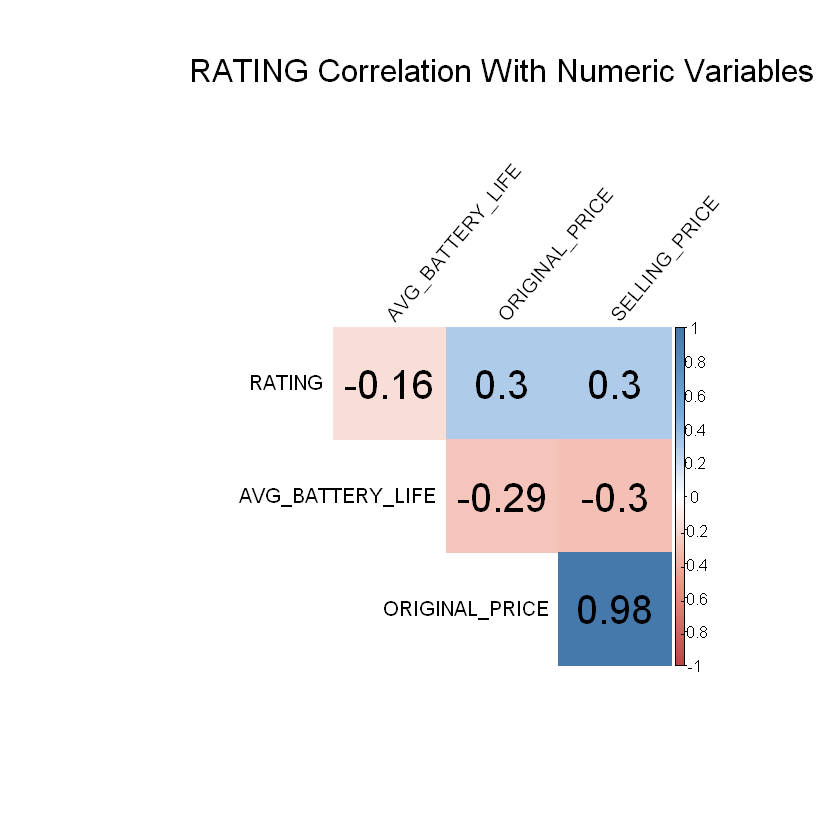

In [24]:
corrplot2(
  data = df1,
  method = "pearson",
  sig.level = .05,
  order = "original",
  diag = FALSE,
  type = "upper",
  tl.srt = 50,
)

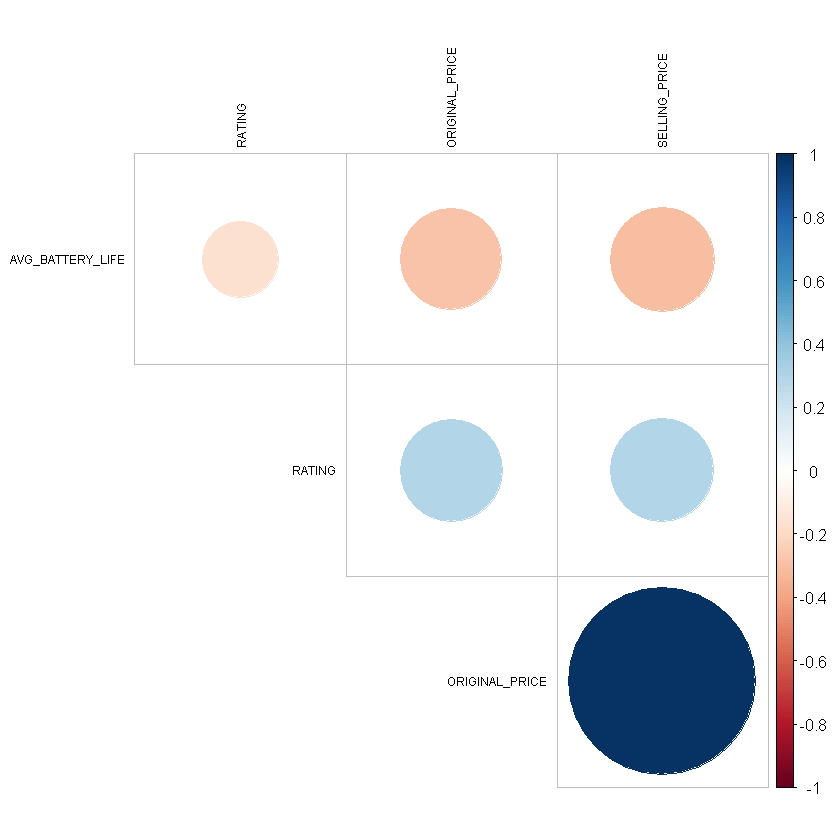

In [25]:
# Alternative correlation plot showing circles. I prefer the 1st one above that shows the values.

set.seed(123)
rmat <- df1
M <- cor(rmat)
corrplot(M, type = "upper", tl.pos = "td",
         method = "circle", tl.cex = 0.6, tl.col = 'black',
         order = "hclust", diag = FALSE)

<b>Results :</b>

RATING : AVG_BATTERY_LIFE - Poor<br>
RATING : ORIGINAL_PRICE and SELLING_PRICE - Moderate 

<hr></hr>
<b>mixed_assoc.R</b><br>
    <i>from (https://github.com/holgerbrandl/datautils/blob/master/R/stats/mixed_assoc.R)</i>

- For correlating mixed type variables

In [27]:
# mixed_assoc function - slightly modified to round off assoc values

if("rcompanion" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("rcompanion")}
if("corrr" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("corrr")}
require(tidyverse)
require(rcompanion)

#pacman::p_load(rcompanion)


# Calculate a pairwise association between all variables in a data-frame. In 
# particular nominal vs nominal with Chi-square, numeric vs numeric with 
# Pearson correlation, and nominal vs numeric with ANOVA.
# Adopted from https://stackoverflow.com/a/52557631/590437
mixed_assoc = function(df, cor_method="pearson", adjust_cramersv_bias=TRUE){
    df_comb = expand.grid(names(df), names(df),  stringsAsFactors = F) %>% 
        set_names("X1", "X2")

    is_nominal = function(x) class(x) %in% c("factor", "character")
    # https://community.rstudio.com/t/why-is-purr-is-numeric-deprecated/3559
    # https://github.com/r-lib/rlang/issues/781
    is_numeric <- function(x) { is.integer(x) || is_double(x)}

    f = function(xName,yName) {
        x =  pull(df, xName)
        y =  pull(df, yName)

        result = if(is_nominal(x) && is_nominal(y)){
            # use bias corrected cramersV as described in 
            # https://rdrr.io/cran/rcompanion/man/cramerV.html
            cv = round(cramerV(as.character(x), as.character(y), 
                         bias.correct = adjust_cramersv_bias),digits = 2)
            data.frame(xName, yName, assoc=round(cv,2), type="cramersV")

        }else if(is_numeric(x) && is_numeric(y)){
            correlation = round(cor(x, y, method=cor_method, 
                                    use="complete.obs"),digits = 2)
            data.frame(xName, yName, assoc=round(correlation,2), 
                       type="correlation")

        }else if(is_numeric(x) && is_nominal(y)){
            # from https://stats.stackexchange.com/questions/119835/
            # correlation-between-a-nominal-iv-and-a-continuous-dv-variable/
            #124618#124618
            r_squared = summary(lm(x ~ y))$r.squared
            data.frame(xName, yName, assoc=round(sqrt(r_squared),2), 
                       type="anova")

        }else if(is_nominal(x) && is_numeric(y)){
            r_squared = summary(lm(y ~x))$r.squared
            data.frame(xName, yName, assoc=round(sqrt(r_squared),2), 
                       type="anova")

        }else {
            warning(paste("unmatched column type combination: ", class(x), 
                            class(y)))
        }

        # finally add complete obs number and ratio to table
        result %>% mutate(complete_obs_pairs=sum(!is.na(x) & !is.na(y)), 
                        complete_obs_ratio=complete_obs_pairs/length(x)) %>% 
                        rename(x=xName, y=yName)
    }

    # apply function to each variable combination
    map2_df(df_comb$X1, df_comb$X2, f)
}

In [28]:
# Show correlation between RATING and categorical variables

df2 <- select(df, RATING, BRAND_NAME, MODEL_NAME, DISPLAY,
                     STRAP_MATERIAL, COLOR)

dfResult <- mixed_assoc(df2) %>% select(x,y,assoc,type)
filter(dfResult, x != y & x == 'RATING')


,x,y,assoc,type
,<chr>,<chr>,<dbl>,<chr>
...1,RATING,BRAND_NAME,0.46,anova
...2,RATING,MODEL_NAME,0.97,anova
...3,RATING,DISPLAY,0.42,anova
...4,RATING,STRAP_MATERIAL,0.42,anova
...5,RATING,COLOR,0.45,anova


<b>RESULTS :</b>

One Very Strong correlation between MODEL_NAME and RATING

The rest are ALL Moderate correlation

<h2>Section 6 : Find out Top 10 Brands Listed By Quantity</h2>

<b>Section 6A - using mongoDB object</b>

<b>*** Skip to Section 6B if no mongoDB connection</b>

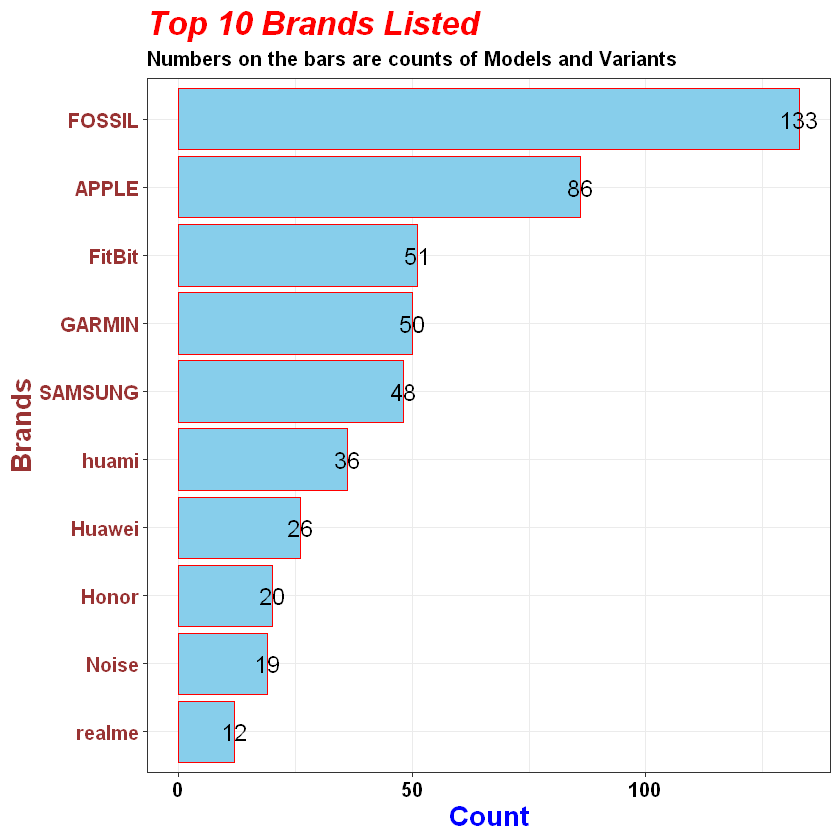

In [41]:
# Use the mongodb object

g <- ft$aggregate('[{ "$group" : 
                      { "_id" : "$BRAND_NAME", 
                        "Count" : { "$sum" : 1}
                      }
                  }]')%>%na.omit()%>%arrange(desc(Count))%>%head(10)%>%
ggplot(aes(x=reorder(`_id`,Count),y=Count))+
geom_bar(stat="identity",color='red',fill='skyblue')+
    geom_text(aes(label = Count), color = 'black', size=5) +
    coord_flip()+labs(title="Top 10 Brands Listed", 
        subtitle="Numbers on the bars are counts of Models and Variants", 
        y="Count", 
        x="Brands")

# Change the color, the size and the face of
# the main title, x and y axis labels
g + theme(
plot.title = element_text(color="red", size=20, face="bold.italic"),
plot.subtitle = element_text(color="black", size=12, face="bold"),
axis.text.x = element_text(color="black", size=12, face="bold"),
axis.title.x = element_text(color="blue", size=16, face="bold"),
axis.text.y = element_text(color="#993333", size=12, face="bold"),
axis.title.y = element_text(color="#993333", size=16, face="bold")
)

<b>Section 6B - using R object</b>

<b>*** Skip to Section 7 if able to run Section 6A above - i.e. with mongoDB connection</b>


 FOSSIL   APPLE  FitBit  GARMIN SAMSUNG   huami  Huawei   Honor   Noise  realme 
    133      86      51      50      48      36      26      20      19      12 

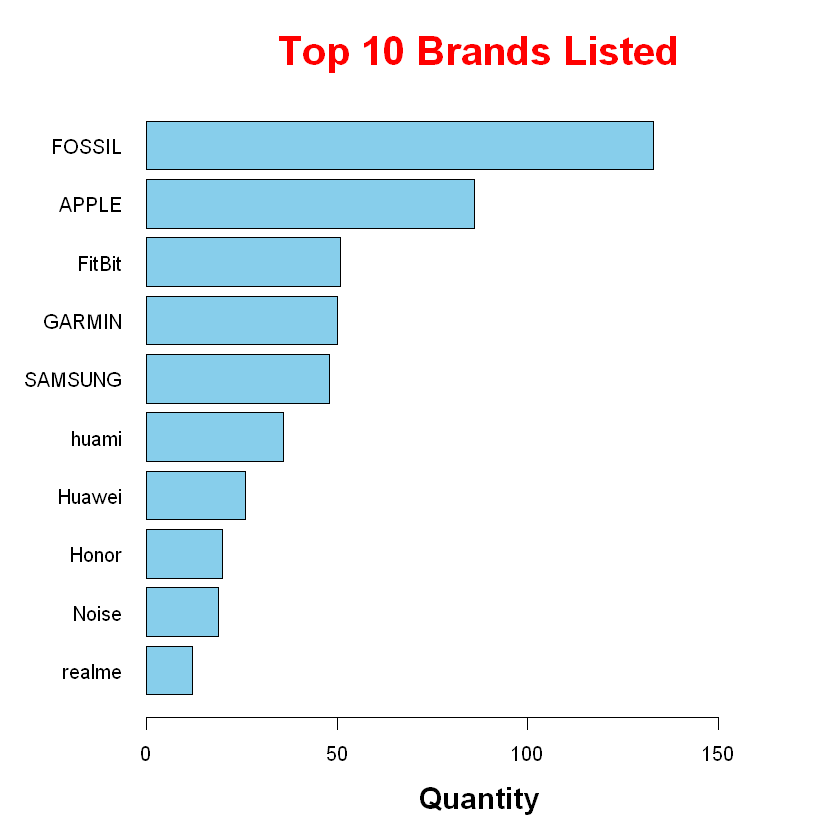

In [43]:
# Use the regular R object

count <- table(df$BRAND_NAME)
count <- head(sort(count, decreasing=TRUE),10)
count
par(mar=c(5,6,4,1)+.1)     # add margin to left side

barplot(sort(count), horiz='TRUE', las=2, axes=FALSE, col="skyblue", 
        xlim = c(0,175),
        main="Top 10 Brands Listed", 
            font.main=2, 
            cex.main = 2, 
            col.main="red", 
        xlab = "Quantity",     
            font.lab = 2, 
            cex.lab = 1.5,
            col.lab="Black"
        )
axis(1, las=1)   # x separated to show labels horizontally

<h2>Section 7 : More Analysis</h2>

<h2>Find out Which Brands Have The Highest Number Of Ratings</h2>

In [30]:
# Back to use dataframe object, filtered by RATING >= 4 into a new dataframe
# dftr (df Top Ratings)

dftr <- filter(df, RATING >= 4)

# Combine Brand.Name + Model.Name into Product.Name in case some 
# models between brands have the same name

dftr["PRODUCT_NAME"] <- paste(dftr$BRAND_NAME, dftr$MODEL_NAME, dftr$COLOR)

count <- table(dftr$BRAND_NAME)
sort(count, decreasing = T)

#par(mar=c(5,6,4,1)+.1)     # add margin to left side


  FOSSIL    APPLE   FitBit  SAMSUNG   GARMIN    huami   Huawei    Honor 
     107       85       44       40       32       32       21       17 
  realme    Noise   Xiaomi Fastrack  OnePlus     boAt 
      12       10        9        5        3        2 

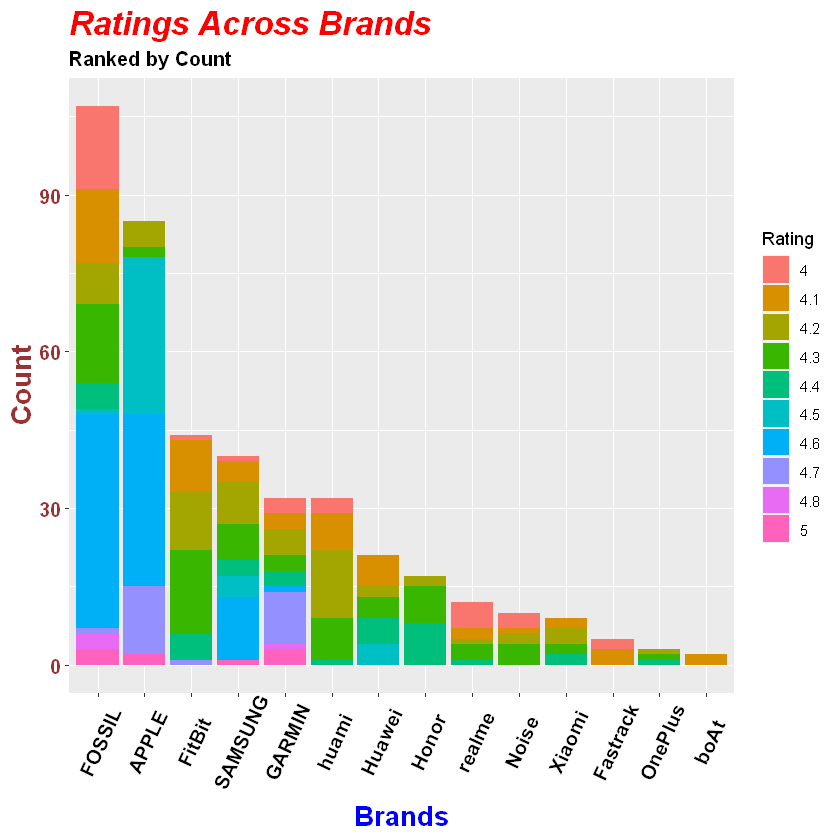

In [32]:
library(forcats)    # offers a really handy function: fct_infreq() reorders 
                    # according to a factor value’s frequency

g1 <- ggplot(dftr, aes(x = fct_infreq(BRAND_NAME)))

g1 <- g1 + geom_bar(stat = 'count',aes(fill=as.factor(RATING)), width = .9)+
    theme(axis.text.x = element_text(angle=65, vjust=0.6)) + 
    labs(title="Ratings Across Brands", 
         subtitle="Ranked by Count",
    x="Brands", y="Count",fill = "Rating")

# Change the color, the size and the face of
# the main title, x and y axis labels
g1 <- g1 + theme(
plot.title = element_text(color="red", size=20, face="bold.italic"),
plot.subtitle = element_text(color="black", size=12, face="bold"),
axis.text.x = element_text(color="black", size=12, face="bold"),
axis.title.x = element_text(color="blue", size=16, face="bold"),
axis.text.y = element_text(color="#993333", size=12, face="bold"),
axis.title.y = element_text(color="#993333", size=16, face="bold")
)

g1

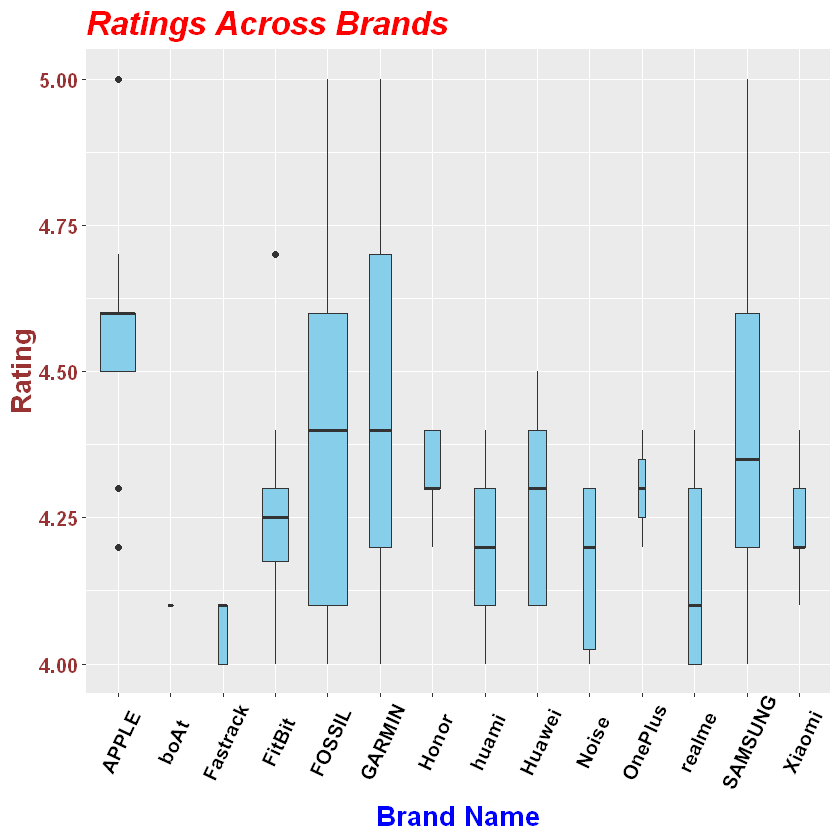

In [33]:
# Box Plot

g <- ggplot(dftr, aes(BRAND_NAME, RATING))

g <- g + geom_boxplot(varwidth=T, fill="skyblue") + 
theme(axis.text.x = element_text(angle=65, vjust=0.6)) + 
    labs(title="Ratings Across Brands", 
         x="Brand Name",
         y="Rating")

# Change the color, the size and the face of
# the main title, x and y axis labels
g + theme(
plot.title = element_text(color="red", size=20, face="bold.italic"),
axis.text.x = element_text(color="black", size=12, face="bold"),
axis.title.x = element_text(color="blue", size=16, face="bold"),
axis.text.y = element_text(color="#993333", size=12, face="bold"),
axis.title.y = element_text(color="#993333", size=16, face="bold")
)

<b>PRELIMINARY CONCLUSION:</b>

The charts show the distribution of ratings per brand, distinguished by colors.  

The top 10 brands with the highest ratings also match exactly the top 10 brands based on quantity 
listed.  This is expected as these top 10 brands have the most quantity of items on the list.

We can further extract information about models and variants (color, strap, etc) from the 
filtered dataset.

<h2>Rating Performance Across Brands</h2><br>
Compare the position or performance of multiple items with respect to each other, in this case,
BRAND_NAME vs RATING. Actual values matters somewhat less than the ranking.

In [34]:
# Prepare data: group count by manufacturer.
dfbr <- aggregate(dftr$RATING, by=list(dftr$BRAND_NAME), FUN=mean)  # aggregate

colnames(dfbr) <- c("BRAND_NAME", "RATING")  # change column names

dfbr <- dfbr[order(dfbr$RATING), ]  # sort
dfbr$BRAND_NAME <- factor(dfbr$BRAND_NAME, levels = dfbr$BRAND_NAME)  # to retain the order in plot.

dfbr[order(-dfbr$RATING),]

,BRAND_NAME,RATING
,<fct>,<dbl>
1,APPLE,4.558824
6,GARMIN,4.462500
13,SAMSUNG,4.387500
5,FOSSIL,4.380374
7,Honor,4.335294
11,OnePlus,4.300000
9,Huawei,4.295238
14,Xiaomi,4.244444
4,FitBit,4.243182


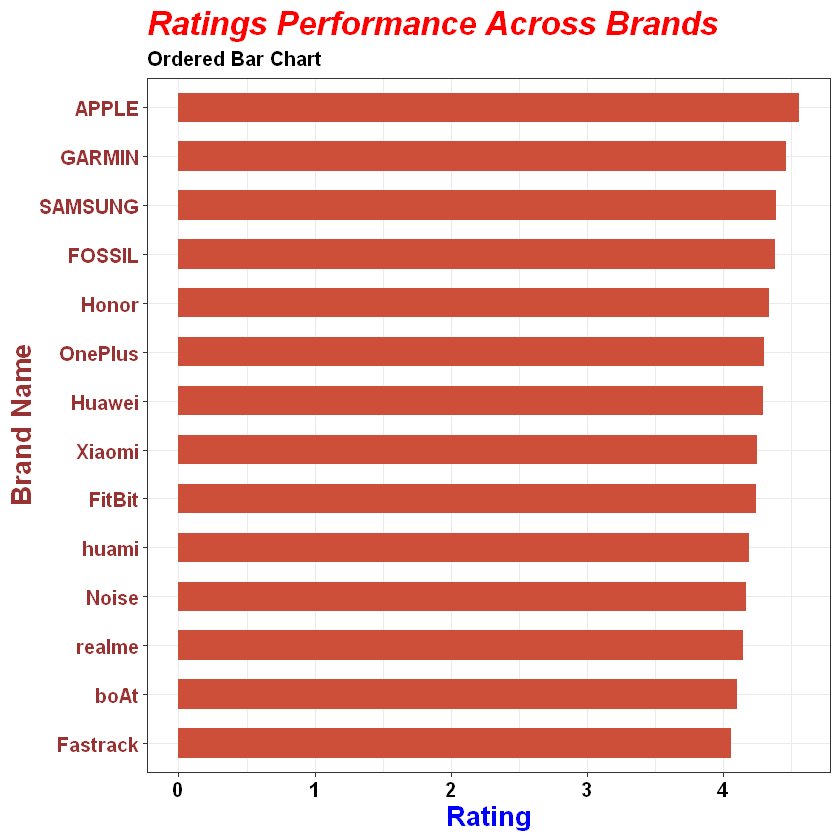

In [35]:
theme_set(theme_bw())

# Draw plot
g2 <- ggplot(dfbr, aes(x=BRAND_NAME, y=RATING)) + 
  geom_bar(stat="identity", width=.6, fill="tomato3") + 
  coord_flip()+labs(title="Ratings Performance Across Brands", 
       subtitle="Ordered Bar Chart", 
         x="Brand Name",
         y="Rating")

# Change the color, the size and the face of
# the main title, x and y axis labels
g2 <- g2 + theme(
plot.title = element_text(color="red", size=20, face="bold.italic"),
plot.subtitle = element_text(color="black", size=12, face="bold"),
axis.text.x = element_text(color="black", size=12, face="bold"),
axis.title.x = element_text(color="blue", size=16, face="bold"),
axis.text.y = element_text(color="#993333", size=12, face="bold"),
axis.title.y = element_text(color="#993333", size=16, face="bold")
)

g2

<b>Conclusion :</b>
Here we can see brand names arranged according to the rating scores they received.

Refer to the cell below.  
   - The first image shows the brands arranged by ratings count.
   - The second image shows the brands arranged by ratings performance.

<b>OnePlus and Xiaomi were not in the top 10 of the 1st image, but are now in the top 10 of best
performing brands with respect to ratings.</b>

Our recommendation for the brands to be carried by the company will now be increased from 10 to 12, 
to include OnePlus and Xiaomi.

It can be whittled down back to 10 or left at 12, after the company receives the vendors' offered
dealer prices and terms, for further analysis, since manufacturers all offer different profit 
margins and terms. 

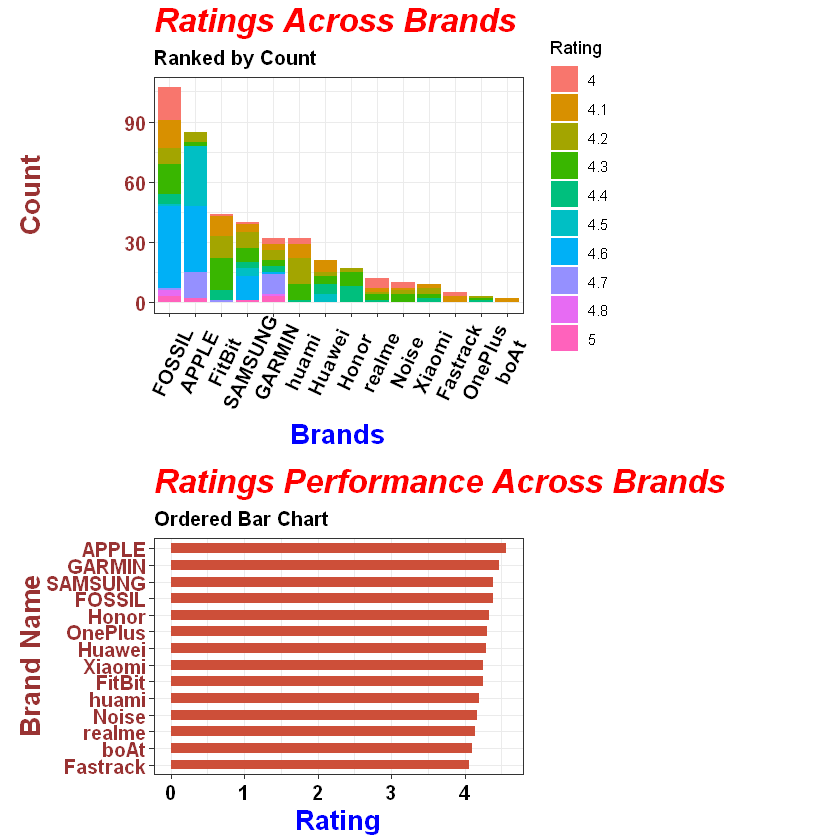

In [36]:
g1 + plot_spacer()  + g2 + plot_layout(widths = c(2, 1), heights = unit(c(5, 5), c('cm', 'cm')))

In [38]:
brand = readline(prompt = "Enter Brand : ")
brand = str_trim(brand)
brand
c <- toupper(brand) %in% toupper(dftr$BRAND_NAME)

if (c == FALSE) {
    print("NOT found, Please Try Again")
}else {

    dfBrand <- filter(dftr, BRAND_NAME == brand)
    head(dfBrand, 3)
}

Enter Brand : APPLE


[1] "APPLE"

,BRAND_NAME,DEVICE_TYPE,MODEL_NAME,COLOR,SELLING_PRICE,ORIGINAL_PRICE,DISPLAY,RATING,STRAP_MATERIAL,AVG_BATTERY_LIFE,PRODUCT_NAME
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<int>,<chr>
1,APPLE,Smartwatch,Series 3 GPS - 42 mm Space Gre,Black,18900,23900,OLED Retina Dis,4.6,Aluminium,1,APPLE Series 3 GPS - 42 mm Space Gre Black
2,APPLE,Smartwatch,SE 44 mm Space Grey Aluminium,Black,30400,32900,OLED Retina Dis,4.7,Aluminium,1,APPLE SE 44 mm Space Grey Aluminium Black
3,APPLE,Smartwatch,Series 3 GPS - 38 mm Space Gre,Black,16900,20900,OLED Retina Dis,4.6,Aluminium,1,APPLE Series 3 GPS - 38 mm Space Gre Black


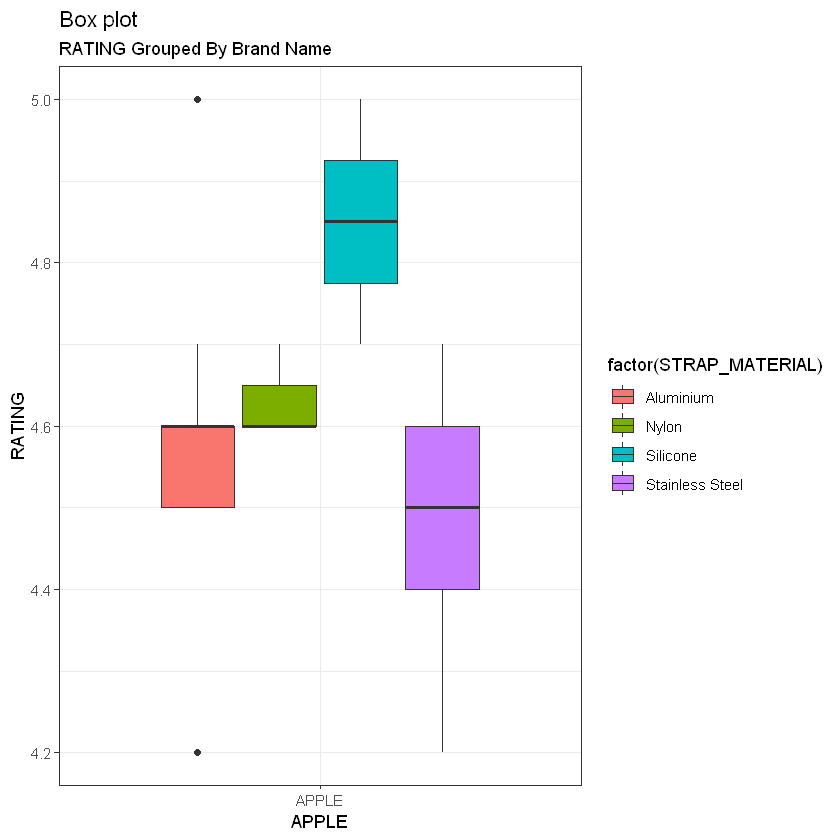

In [49]:
g <- ggplot(dfBrand, aes(BRAND_NAME, RATING))
g + geom_boxplot(aes(fill=factor(STRAP_MATERIAL))) +  
  labs(title="Box plot", 
       subtitle="RATING Grouped By Brand Name",
       x=brand,
       y="RATING")

In [55]:
brand = readline(prompt = "Enter Brand : ")
brand = str_trim(brand)
brand
c <- toupper(brand) %in% toupper(dftr$BRAND_NAME)

if (c == FALSE) {
    print("NOT found, Please Try Again")
}else {

    dfBrand <- filter(dftr, BRAND_NAME == brand)
    head(dfBrand, 3)
}

Enter Brand : APPLE


[1] "APPLE"

,BRAND_NAME,DEVICE_TYPE,MODEL_NAME,COLOR,SELLING_PRICE,ORIGINAL_PRICE,DISPLAY,RATING,STRAP_MATERIAL,AVG_BATTERY_LIFE,PRODUCT_NAME
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<int>,<chr>
1,APPLE,Smartwatch,Series 3 GPS - 42 mm Space Gre,Black,18900,23900,OLED Retina Dis,4.6,Aluminium,1,APPLE Series 3 GPS - 42 mm Space Gre Black
2,APPLE,Smartwatch,SE 44 mm Space Grey Aluminium,Black,30400,32900,OLED Retina Dis,4.7,Aluminium,1,APPLE SE 44 mm Space Grey Aluminium Black
3,APPLE,Smartwatch,Series 3 GPS - 38 mm Space Gre,Black,16900,20900,OLED Retina Dis,4.6,Aluminium,1,APPLE Series 3 GPS - 38 mm Space Gre Black


In [140]:
dfBrand


BRAND_NAME,DEVICE_TYPE,MODEL_NAME,COLOR,SELLING_PRICE,ORIGINAL_PRICE,DISPLAY,RATING,STRAP_MATERIAL,AVG_BATTERY_LIFE,PRODUCT_NAME
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<int>,<chr>
APPLE,Smartwatch,Series 3 GPS - 42 mm Space Gre,Black,18900,23900,OLED Retina Dis,4.6,Aluminium,1,APPLE Series 3 GPS - 42 mm Space Gre Black
APPLE,Smartwatch,SE 44 mm Space Grey Aluminium,Black,30400,32900,OLED Retina Dis,4.7,Aluminium,1,APPLE SE 44 mm Space Grey Aluminium Black
APPLE,Smartwatch,Series 3 GPS - 38 mm Space Gre,Black,16900,20900,OLED Retina Dis,4.6,Aluminium,1,APPLE Series 3 GPS - 38 mm Space Gre Black
APPLE,Smartwatch,SE GPS + Cellular 44 mm Alumin,Black,36900,36900,OLED Retina Dis,4.6,Aluminium,1,APPLE SE GPS + Cellular 44 mm Alumin Black
APPLE,Smartwatch,SE GPS + Cellular 40 mm Space,Charcoal,31400,33900,OLED Retina Dis,4.6,Aluminium,1,APPLE SE GPS + Cellular 40 mm Space Charcoal
APPLE,Smartwatch,SE 40 mm Space Grey Aluminium,"Black, Pink, White",27400,29900,OLED Retina Dis,4.7,Aluminium,1,"APPLE SE 40 mm Space Grey Aluminium Black, Pink, White"
APPLE,Smartwatch,Series 6 GPS + Cellular 40 mm,Red,45690,49900,OLED Retina Dis,4.5,Aluminium,1,APPLE Series 6 GPS + Cellular 40 mm Red
APPLE,Smartwatch,SE 44 mm Gold Aluminium Case,Pink Sand,30400,32900,OLED Retina Dis,4.7,Aluminium,1,APPLE SE 44 mm Gold Aluminium Case Pink Sand
APPLE,Smartwatch,SE GPS + Cellular 40 mm Gold A,Plum,31400,33900,OLED Retina Dis,4.6,Aluminium,1,APPLE SE GPS + Cellular 40 mm Gold A Plum
